In [42]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import hvplot.pandas
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras_tuner as kt
import xarray as xr

#  Import and read the charity_data.csv.
application_df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


## Preprocessing

In [43]:
# Drop the non-beneficial ID columns, EIN, ask
application_df.drop(columns=['EIN','STATUS'], inplace=True)
application_df.head()

,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,0,N,5000,1
1,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1-9999,N,108590,1
2,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,0,N,5000,0
3,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,10000-24999,N,6692,1
4,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,100000-499999,N,142590,1


# Preprocessing

In an effort to optimize the model, I decided to try and redo the preprocessing. I took a look at what I felt were key columns, and created a success rate metric, success/(success+fail). I used that to further identify areas that could help create a stronger, but not overfitting model.

# Name Count Analysis, how many submissions per name

In [44]:
# Group by 'NAME' and count occurrences
name_counts = application_df.groupby('NAME').size()

# Group by 'NAME' and count occurrences of 'IS_SUCCESSFUL' equal to 1, creating the unsuccessful counts variable allowed us to help track total efforts, to get a better perfromance view.
success_counts = application_df[application_df['IS_SUCCESSFUL'] == 1].groupby('NAME').size()
unsuccessful_counts = application_df[application_df['IS_SUCCESSFUL'] == 0].groupby('NAME').size()

# Combine the counts into a single DataFrame
name_stats_df = pd.DataFrame({'name_counts': name_counts, 'Success_Count': success_counts, 'Unsuccessful_Counts': unsuccessful_counts}).fillna(0).astype(int)

# Calculate 'Success Rate' by dividing 'Success_Count' by ('Unsuccessful_Counts' + 1) to avoid division by zero errors

name_stats_df['Success Rate %'] = name_stats_df['Success_Count'] / (name_stats_df['Success_Count'] + name_stats_df['Unsuccessful_Counts'])

# Round 'Success Rate' to 2 decimal points, because nobody needs decimal 
name_stats_df['Success Rate %'] = name_stats_df['Success Rate %'].round(2)

# Sort the DataFrame by 'Name_Count' column in descending order
sorted_name_count = name_stats_df.sort_values(by='name_counts', ascending=False)

# Reset the index to make 'NAME' a column again
sorted_name_count = sorted_name_count.reset_index()

# Display the resulting DataFrame
print(sorted_name_count.shape)
sorted_name_count.head()


(19568, 5)


,NAME,name_counts,Success_Count,Unsuccessful_Counts,Success Rate %
0,PARENT BOOSTER USA INC,1260,208,1052,0.17
1,TOPS CLUB INC,765,14,751,0.02
2,UNITED STATES BOWLING CONGRESS INC,700,16,684,0.02
3,WASHINGTON STATE UNIVERSITY,492,170,322,0.35
4,AMATEUR ATHLETIC UNION OF THE UNITED STATES INC,408,17,391,0.04


In [45]:
# Assuming sorted_name_count is your DataFrame
# Binning based on 'Success Rate %' column
binned_data = sorted_name_count.hvplot.scatter(
    x='Success Rate %',
    y='name_counts',
    c='Success_Count',
    cmap='viridis',
    width=1200, 
    height=400
)

# Display the binned scatter plot
binned_data

:Scatter   [Success Rate %]   (name_counts,Success_Count)

In [46]:
sorted_name_count_clean=sorted_name_count[sorted_name_count['name_counts'] >= 5]

In [47]:
# Assuming sorted_name_count is your DataFrame
# Binning based on 'Success Rate %' column
binned_data2 = sorted_name_count_clean.hvplot.scatter(
    x='Success Rate %',
    y='name_counts',
    c='Success_Count',
    cmap='viridis',
    width=1200, 
    height=400
)

# Display the binned scatter plot
binned_data2

:Scatter   [Success Rate %]   (name_counts,Success_Count)

In [48]:
name_focus_list = sorted_name_count_clean['NAME'].tolist()
print(name_focus_list)

['PARENT BOOSTER USA INC', 'TOPS CLUB INC', 'UNITED STATES BOWLING CONGRESS INC', 'WASHINGTON STATE UNIVERSITY', 'AMATEUR ATHLETIC UNION OF THE UNITED STATES INC', 'PTA TEXAS CONGRESS', 'SOROPTIMIST INTERNATIONAL OF THE AMERICAS INC', 'ALPHA PHI SIGMA', 'TOASTMASTERS INTERNATIONAL', 'MOST WORSHIPFUL STRINGER FREE AND ACCEPTED MASONS', 'LITTLE LEAGUE BASEBALL INC', 'INTERNATIONAL ASSOCIATION OF LIONS CLUBS', 'MOMS CLUB', 'INTERNATIONAL ASSOCIATION OF SHEET METAL AIR RAIL & TRANSPORTATION', 'AMERICAN ASSOCIATION OF UNIVERSITY WOMEN', 'FARMERS EDUCATIONAL AND COOPERATIVE UNION OF AMERICA', 'KNIGHTS OF COLUMBUS', 'HABITAT FOR HUMANITY INTERNATIONAL INC', 'TENNESSEE ORDER OF THE EASTERN STAR', 'VETERANS OF FOREIGN WARS OF THE UNITED STATES AUXILIARY', 'PTA UTAH CONGRESS', 'THE UNITED STATES PONY CLUBS INC', 'CIVITAN INTERNATIONAL', 'SIGMA BETA DELTA INC', 'HONOR SOCIETY OF PHI KAPPA PHI', 'MONTANA 4-H FOUNDATION INC', 'WASHINGTON STATE GRANGE', 'UNIVERSITY OF WYOMING', 'DEMOLAY INTERNATIONA

# Affiliation Count analysis

In [49]:
#in an effort to optimize the model, I decided to try and redo the preprocessing, by taking a look at the classification and evaluating based upon a 
#pass/fail success rate, which is the success/(success+fail) I used that to identify classifications that would benefit most from further modeling. The
#the goal was to identify the gray area and train on that area as the other areas are pretty clear cut and easy to see.

# Group by 'NAME' and count occurrences
AFFILIATION_counts = application_df.groupby('AFFILIATION').size()

# Group by 'NAME' and count occurrences of 'IS_SUCCESSFUL' equal to 1
success_counts = application_df[application_df['IS_SUCCESSFUL'] == 1].groupby('AFFILIATION').size()
unsuccessful_counts = application_df[application_df['IS_SUCCESSFUL'] == 0].groupby('AFFILIATION').size()

# Combine the counts into a single DataFrame
AFFILIATION_stats_df = pd.DataFrame({'AFFILIATION counts': AFFILIATION_counts, 'Success_Count': success_counts, 'Unsuccessful_Counts': unsuccessful_counts}).fillna(0).astype(int)

# Calculate 'Success Rate' by dividing 'Success_Count' by ('Unsuccessful_Counts' + 1) to avoid division by zero errors

AFFILIATION_stats_df['Success Rate %'] = AFFILIATION_stats_df['Success_Count'] / (AFFILIATION_stats_df['Success_Count'] + AFFILIATION_stats_df['Unsuccessful_Counts'])


# Round 'Success Rate' to 2 decimal points
AFFILIATION_stats_df['Success Rate %'] = AFFILIATION_stats_df['Success Rate %'].round(2)

# Sort the DataFrame by 'Name_Count' column in descending order
sorted_AFFILIATION_counts = AFFILIATION_stats_df.sort_values(by='Success Rate %', ascending=False)

# Reset the index to make 'NAME' a column again
sorted_AFFILIATION_counts = sorted_AFFILIATION_counts.reset_index()

# Display the resulting DataFrame
sorted_AFFILIATION_counts.head(20)


,AFFILIATION,AFFILIATION counts,Success_Count,Unsuccessful_Counts,Success Rate %
0,Other,4,4,0,1.00
1,Independent,18480,12981,5499,0.70
2,Regional,13,8,5,0.62
3,National,33,20,13,0.61
4,Family/Parent,64,36,28,0.56
5,CompanySponsored,15705,5212,10493,0.33


# Classification Count Analysis

In [50]:
# Group by 'NAME' and count occurrences
classification_counts = application_df.groupby('CLASSIFICATION').size()

# Group by 'NAME' and count occurrences of 'IS_SUCCESSFUL' equal to 1
success_counts = application_df[application_df['IS_SUCCESSFUL'] == 1].groupby('CLASSIFICATION').size()
unsuccessful_counts = application_df[application_df['IS_SUCCESSFUL'] == 0].groupby('CLASSIFICATION').size()

# Combine the counts into a single DataFrame
CLASSIFICATION_stats_df = pd.DataFrame({'Classification_Counts': classification_counts, 'Success_Count': success_counts, 'Unsuccessful_Counts': unsuccessful_counts}).fillna(0).astype(int)

# Calculate 'Success Rate' by dividing 'Success_Count' by ('Unsuccessful_Counts' + 1) to avoid division by zero errors

CLASSIFICATION_stats_df['Success Rate %'] = CLASSIFICATION_stats_df['Success_Count'] / (CLASSIFICATION_stats_df['Success_Count'] + CLASSIFICATION_stats_df['Unsuccessful_Counts'])


# Round 'Success Rate' to 2 decimal points
CLASSIFICATION_stats_df['Success Rate %'] = CLASSIFICATION_stats_df['Success Rate %'].round(2)

# Sort the DataFrame by 'Name_Count' column in descending order
sorted_classification_count = CLASSIFICATION_stats_df.sort_values(by='Success Rate %', ascending=False)

# Reset the index to make 'NAME' a column again
sorted_classification_count = sorted_classification_count.reset_index()

# Display the resulting DataFrame
sorted_classification_count.head()


,CLASSIFICATION,Classification_Counts,Success_Count,Unsuccessful_Counts,Success Rate %
0,C1900,1,1,0,1.0
1,C1278,10,10,0,1.0
2,C1370,1,1,0,1.0
3,C1570,1,1,0,1.0
4,C1580,1,1,0,1.0


In [51]:
# Assuming sorted_name_count is your DataFrame
# Binning based on 'Success Rate %' column
binned_data = sorted_classification_count.hvplot.scatter(
    x='Success Rate %',
    y='Classification_Counts',
    by='Success Rate %',
    agg='mean',
    width=800, 
    height=400
)

# Display the binned scatter plot
binned_data

:NdOverlay   [Success Rate %]
   :Scatter   [Success Rate %]   (Classification_Counts)

In [52]:
sorted_classification_count.iloc[25:65]

,CLASSIFICATION,Classification_Counts,Success_Count,Unsuccessful_Counts,Success Rate %
25,C1235,9,9,0,1.00
26,C7100,75,68,7,0.91
27,C1238,10,9,1,0.90
28,C7000,777,694,83,0.89
29,C7200,32,28,4,0.88
30,C1800,15,13,2,0.87
31,C6000,15,13,2,0.87
32,C1230,36,30,6,0.83
33,C4000,194,161,33,0.83
34,C7120,18,15,3,0.83


In [53]:

classification_by_success_rate = sorted_classification_count[(sorted_classification_count['Success Rate %'] > 0.45) & (sorted_classification_count['Success Rate %'] <= 0.6)]
classification_by_success_rate.head(20)

,CLASSIFICATION,Classification_Counts,Success_Count,Unsuccessful_Counts,Success Rate %
49,C1700,287,173,114,0.60
50,C2800,95,57,38,0.60
51,C1000,17326,9760,7566,0.56
52,C2000,6074,3231,2843,0.53
53,C1267,2,1,1,0.50
54,C3200,2,1,1,0.50
55,C3000,1918,930,988,0.48
56,C1200,4837,2238,2599,0.46


In [54]:
classification_by_success_rate_trim = classification_by_success_rate[classification_by_success_rate['Classification_Counts'] > 300]
classification_by_success_rate_trim

,CLASSIFICATION,Classification_Counts,Success_Count,Unsuccessful_Counts,Success Rate %
51,C1000,17326,9760,7566,0.56
52,C2000,6074,3231,2843,0.53
55,C3000,1918,930,988,0.48
56,C1200,4837,2238,2599,0.46


In [55]:
classification_by_success_rate_trim.hvplot.scatter(
    y="Classification_Counts",
    x="Success Rate %"
)

:Scatter   [Success Rate %]   (Classification_Counts)

In [56]:
classification_focus_list = classification_by_success_rate_trim['CLASSIFICATION'].tolist()
print(classification_focus_list)

['C1000', 'C2000', 'C3000', 'C1200']


#Application_type Count Analysis

In [57]:
# Group by 'NAME' and count occurrences
application_counts = application_df.groupby('APPLICATION_TYPE').size()

# Group by 'NAME' and count occurrences of 'IS_SUCCESSFUL' equal to 1
success_counts = application_df[application_df['IS_SUCCESSFUL'] == 1].groupby('APPLICATION_TYPE').size()
unsuccessful_counts = application_df[application_df['IS_SUCCESSFUL'] == 0].groupby('APPLICATION_TYPE').size()

# Combine the counts into a single DataFrame
application_stats_df = pd.DataFrame({'Application_Counts': application_counts, 'Success_Count': success_counts, 'Unsuccessful_Counts': unsuccessful_counts}).fillna(0).astype(int)

# Calculate 'Success Rate' by dividing 'Success_Count' by ('Unsuccessful_Counts' + 1) to avoid division by zero errors

application_stats_df['Success Rate %'] = application_stats_df['Success_Count'] / (application_stats_df['Success_Count'] + application_stats_df['Unsuccessful_Counts'])


# Round 'Success Rate' to 2 decimal points
application_stats_df['Success Rate %'] = application_stats_df['Success Rate %'].round(2)

# Sort the DataFrame by 'Name_Count' column in descending order
sorted_application_rate = application_stats_df.sort_values(by='Application_Counts', ascending=False)

# Reset the index to make 'NAME' a column again
sorted_application_rate = sorted_application_rate.reset_index()

# Display the resulting DataFrame
sorted_application_rate.head(40)


,APPLICATION_TYPE,Application_Counts,Success_Count,Unsuccessful_Counts,Success Rate %
0,T3,27037,14388,12649,0.53
1,T4,1542,471,1071,0.31
2,T6,1216,900,316,0.74
3,T5,1173,900,273,0.77
4,T19,1065,201,864,0.19
5,T8,737,311,426,0.42
6,T7,725,410,315,0.57
7,T10,528,464,64,0.88
8,T9,156,112,44,0.72
9,T13,66,61,5,0.92


In [58]:
# Assuming sorted_name_count is your DataFrame
# Binning based on 'Success Rate %' column
binned_data = sorted_name_count.hvplot.scatter(
    x='Success Rate %',
    y='name_counts',
    by='Success Rate %',
    agg='mean',
    width=800, 
    height=400
)

# Display the binned scatter plot
binned_data

:NdOverlay   [Success Rate %]
   :Scatter   [Success Rate %]   (name_counts)

In [59]:
# Filter rows based on column: 'Success Rate %' and 'Application_Counts'
sorted_application_rate_trim = sorted_application_rate[
    (sorted_application_rate['Success Rate %'] <= 0.8) &
    (sorted_application_rate['Application_Counts'] > 500)
]
# Display the filtered DataFrame
sorted_application_rate_trim.head()


,APPLICATION_TYPE,Application_Counts,Success_Count,Unsuccessful_Counts,Success Rate %
0,T3,27037,14388,12649,0.53
1,T4,1542,471,1071,0.31
2,T6,1216,900,316,0.74
3,T5,1173,900,273,0.77
4,T19,1065,201,864,0.19


In [60]:
sorted_application_rate_trim.hvplot.scatter(
    y="Success Rate %",
    x="APPLICATION_TYPE",
    by="Application_Counts"
)

:NdOverlay   [Application_Counts]
   :Scatter   [APPLICATION_TYPE]   (Success Rate %)

In [61]:
application_focus_list = sorted_application_rate_trim['APPLICATION_TYPE'].tolist()
print(application_focus_list)

['T3', 'T4', 'T6', 'T5', 'T19', 'T8', 'T7']


In [62]:
application_df.head()

,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,0,N,5000,1
1,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1-9999,N,108590,1
2,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,0,N,5000,0
3,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,10000-24999,N,6692,1
4,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,100000-499999,N,142590,1


In [63]:
# Filter the DataFrame to keep only the rows with values in the list
application_af_df = application_df[application_df['APPLICATION_TYPE'].isin(['T7', 'T3', 'T8', 'T4', 'T19'])]



In [64]:
# Assuming 'df' is your DataFrame
application_af_cf_df = application_af_df[application_af_df['CLASSIFICATION'].isin(['C1000', 'C2000', 'C3000', 'C1200'])]

# Display the filtered DataFrame
application_af_cf_df.head()


,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
1,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1-9999,N,108590,1
3,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,10000-24999,N,6692,1
4,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,100000-499999,N,142590,1
5,MINORITY ORGAN & TISSUE TRANSPLANT & EDUCATION...,T3,Independent,C1200,Preservation,Trust,0,N,5000,1
6,FRIENDS OF ARTS COUNCIL OF GREATER DENHAM SPRI...,T3,Independent,C1000,Preservation,Trust,100000-499999,N,31452,1


In [65]:

# Assuming 'df' is your DataFrame
application_af_cf_df_nf = application_af_cf_df[application_af_cf_df['NAME'].isin(name_focus_list)]

In [66]:
application_enc_df=pd.get_dummies(application_af_cf_df_nf)
application_enc_df.head()

,ASK_AMT,IS_SUCCESSFUL,NAME_AACE INTERNATIONAL,NAME_ACE MENTOR PROGRAM OF AMERICA INC,NAME_ACTS MINISTRY,NAME_ACTS MISSIONS,NAME_AIR FORCE ASSOCIATION,NAME_ALABAMA FEDERATION OF WOMENS CLUBS,NAME_ALABAMA TREASURE FOREST ASSOCIATION,NAME_ALBANY STATE UNIVERSITY NATIONAL ALUMNI ASSOCIATION,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
12,5000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
19,376109,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
23,5000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
24,5000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
26,5000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [67]:
# Assuming df is your DataFrame
# Calculate the sum of values in each column
column_sums = application_enc_df.sum(axis=0)

# Print the sum of values in each column
print("Sum of values in each column:")
print(column_sums)


Sum of values in each column:
ASK_AMT                                   2473057383
IS_SUCCESSFUL                                   2830
NAME_AACE INTERNATIONAL                            7
NAME_ACE MENTOR PROGRAM OF AMERICA INC            15
NAME_ACTS MINISTRY                                 4
                                             ...    
INCOME_AMT_25000-99999                           686
INCOME_AMT_50M+                                    8
INCOME_AMT_5M-10M                                 26
SPECIAL_CONSIDERATIONS_N                       10831
SPECIAL_CONSIDERATIONS_Y                           1
Length: 356, dtype: int64


In [68]:
application_enc_df.shape

(10832, 356)

In [69]:
columns_list = application_enc_df.columns.tolist()
columns_list

['ASK_AMT',
 'IS_SUCCESSFUL',
 'NAME_AACE INTERNATIONAL',
 'NAME_ACE MENTOR PROGRAM OF AMERICA INC',
 'NAME_ACTS MINISTRY',
 'NAME_ACTS MISSIONS',
 'NAME_AIR FORCE ASSOCIATION',
 'NAME_ALABAMA FEDERATION OF WOMENS CLUBS',
 'NAME_ALABAMA TREASURE FOREST ASSOCIATION',
 'NAME_ALBANY STATE UNIVERSITY NATIONAL ALUMNI ASSOCIATION',
 'NAME_ALPHA PHI OMEGA',
 'NAME_ALPHA PHI SIGMA',
 'NAME_ALPHA PHI SIGMA INC',
 'NAME_ALPHA SIGMA PHI FRATERNITY INC',
 'NAME_ALTRUSA INTERNATIONAL FOUNDATION INC',
 'NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES',
 'NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES INC',
 'NAME_AMERICAN ART THERAPY ASSOCIATION INC',
 'NAME_AMERICAN ASSOCIATION OF UNIVERSITY WOMEN',
 'NAME_AMERICAN ASSOCIATION OF UNIVERSITY WOMEN INC',
 'NAME_AMERICAN CHEMICAL SOCIETY',
 'NAME_AMERICAN FEDERATION OF STATE COUNTY & MUNICIPAL EMPLOYEES',
 'NAME_AMERICAN HIBISCUS',
 'NAME_AMERICAN INDEPENDENT BUSINESS ALLIANCE',
 'NAME_AMERICAN INSTITUTE OF GRAPHIC ARTS',
 'NAME_AMERICAN IRIS SOCIE

In [70]:
# Split our preprocessed data into our features and target arrays
y = application_enc_df["IS_SUCCESSFUL"]
X = application_enc_df.drop(columns="IS_SUCCESSFUL").values

# Split the preprocessed data into a training and testing dataset
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=13, stratify=y)

In [71]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


## Compile, Train and Evaluate the Model

In [72]:
number_input_features = len(X_train[0])
print(number_input_features)

355


In [73]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
#  YOUR CODE GOES HERE
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  80
hidden_nodes_layer2 = 30
hidden_nodes_layer3 = 5

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="tanh"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="tanh"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 80)                28480     
                                                                 
 dense_5 (Dense)             (None, 30)                2430      
                                                                 
 dense_6 (Dense)             (None, 5)                 155       
                                                                 
 dense_7 (Dense)             (None, 1)                 6         
                                                                 
Total params: 31,071
Trainable params: 31,071
Non-trainable params: 0
_________________________________________________________________


In [74]:
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])



In [75]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
254/254 [==============================] - 1s 2ms/step - loss: 0.3132 - accuracy: 0.8711
Epoch 2/100
  1/254 [..............................] - ETA: 0s - loss: 0.3891 - accuracy: 0.8438

254/254 [==============================] - 0s 1ms/step - loss: 0.2106 - accuracy: 0.9190
Epoch 3/100
254/254 [==============================] - 0s 1ms/step - loss: 0.1962 - accuracy: 0.9234
Epoch 4/100
254/254 [==============================] - 0s 1ms/step - loss: 0.1920 - accuracy: 0.9259
Epoch 5/100
254/254 [==============================] - 0s 972us/step - loss: 0.1877 - accuracy: 0.9253
Epoch 6/100
254/254 [==============================] - 0s 1ms/step - loss: 0.1856 - accuracy: 0.9236
Epoch 7/100
254/254 [==============================] - 0s 1ms/step - loss: 0.1828 - accuracy: 0.9269
Epoch 8/100
254/254 [==============================] - 0s 1ms/step - loss: 0.1810 - accuracy: 0.9273
Epoch 9/100
254/254 [==============================] - 0s 2ms/step - loss: 0.1804 - accuracy: 0.9277
Epoch 10/100
254/254 [==============================] - 0s 1ms/step - loss: 0.1788 - accuracy: 0.9280
Epoch 11/100
254/254 [==============================] - 0s 1ms/step - loss: 0.1781 - accuracy: 0.927

In [76]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

85/85 - 0s - loss: 0.2491 - accuracy: 0.9154 - 99ms/epoch - 1ms/step
Loss: 0.24913376569747925, Accuracy: 0.9154357314109802


In [77]:
# Export our model to HDF5 file
nn.save("AlphabetSoupCharity_Optimization.h5")

In [78]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

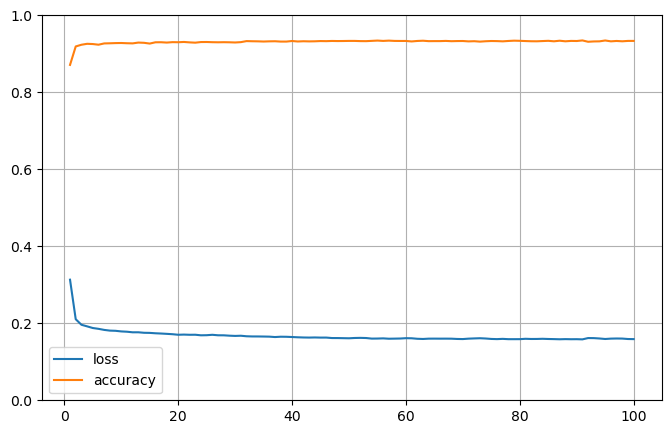

In [79]:


# Plot the loss
history_df.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

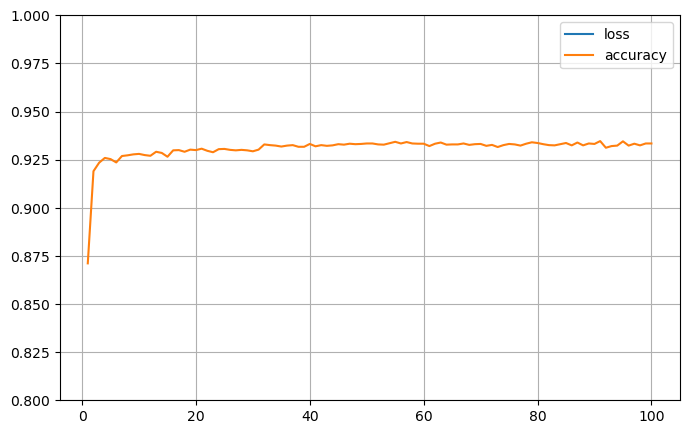

In [80]:
#detailed view of accuracy, less jagged plot indicates less overfitting
history_df.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.8,1)
plt.show()

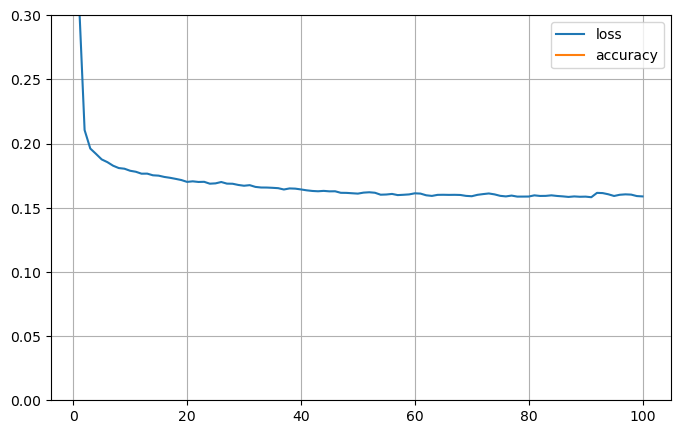

In [81]:
#detailed view of loss
history_df.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,0.3)
plt.show()

In [82]:
# Export our model to HDF5 file
#  YOUR CODE GOES HERE
